# Load Modules

In [59]:
import xml.etree.cElementTree as ET  # Use cElementTree or lxml if too slow
import re
from collections import defaultdict

import sqlite3
import csv
from pprint import pprint

import csv
import codecs
import cerberus

import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("ticks")
sns.set_style("white")
colors = sns.color_palette()
from IPython.display import display

from time import time

In [27]:
# %load schema.py
# Note: The schema is stored in a .py file in order to take advantage of the
# int() and float() type coercion functions. Otherwise it could easily stored as
# as JSON or another serialized format.

schema = {
    'node': {
        'type': 'dict',
        'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'lat': {'required': True, 'type': 'float', 'coerce': float},
            'lon': {'required': True, 'type': 'float', 'coerce': float},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
        }
    },
    'node_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    },
    'way': {
        'type': 'dict',
        'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
        }
    },
    'way_nodes': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'node_id': {'required': True, 'type': 'integer', 'coerce': int},
                'position': {'required': True, 'type': 'integer', 'coerce': int}
            }
        }
    },
    'way_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    }
}


# Extract Sample File

This block creates a smaller file size to work with

In [4]:
OSM_FILE = "ex_w76EfPgoM8PsPLbMqJ93rbViRM5yT.osm"
SAMPLE_FILE = "sample.osm"

k = 7 # Parameter: take every k-th top level element

def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag
    """
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


with open(SAMPLE_FILE, 'wb') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')

    # Write every kth top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8'))

    output.write('</osm>')

# Contributers

This block will find out the user ids of everyone who has contributed to the map in this particular area.

In [23]:
"""
Your task is to explore the data a bit more.
The first task is a fun one - find out how many unique users
have contributed to the map in this particular area!

The function process_map should return a set of unique user IDs ("uid")

To get all the uid's you will need to go through all of tags.  Way tags
have a uid as do relations and nodes.
"""

def get_user(element):
    if element.tag == 'node' or element.tag == 'way' or element.tag == 'relation':
        id = element.attrib['uid']
        return id


def process_map(filename):
    users = set()
    
    # This parses through all elements and that's why there are nulls.  
    # It checks whether it has a uid only after getting to the function, 
    # so it's possible to have a nonetype there
    for _, element in ET.iterparse(filename):
        if get_user(element):
            users.add(get_user(element))
    return users


def test():
    users = process_map('sample.osm')
    print "Number of users:", len(users)
    print "First 5 users:"
    pprint(sorted(list(users))[:5])

if __name__ == "__main__":
    test()

Number of users: 91
First 5 users:
['1034', '113450', '1137433', '116029', '1184150']


# Tags

This block will grab all of the tags from the file

In [12]:
"""
Your task is to use the iterative parsing to process the map file and
find out not only what tags are there, but also how many, to get the
feeling on how much of which data you can expect to have in the map.
Fill out the count_tags function. It should return a dictionary with the 
tag name as the key and number of times this tag can be encountered in 
the map as value.

Note that your code will be tested with a different data file than the 'example.osm'
"""

def count_tags(filename):
    
    # Tag name is key, number of times encountered is value
    # 
    tag_dictionary = {}
    #tree = ET.parse(filename)
    #root = tree.getroot()
    for _, element in ET.iterparse(filename):
        if element.tag in tag_dictionary:
            tag_dictionary[element.tag] += 1
        else:
            tag_dictionary[element.tag] = 1
    return tag_dictionary


def test():
    tags = count_tags('sample.osm')
    pprint(tags)

if __name__ == "__main__":
    test()

{'member': 219,
 'nd': 52821,
 'node': 47012,
 'osm': 1,
 'relation': 16,
 'tag': 18445,
 'way': 5881}


# Checking for Problem Characters

This block will check for problem characters in tags

In [16]:
"""
Your task is to explore the data a bit more.
Before you process the data and add it into your database, you should check the
"k" value for each "<tag>" and see if there are any potential problems.

We have provided you with 3 regular expressions to check for certain patterns
in the tags. As we saw in the quiz earlier, we would like to change the data
model and expand the "addr:street" type of keys to a dictionary like this:
{"address": {"street": "Some value"}}
So, we have to see if we have such tags, and if we have any tags with
problematic characters.

Please complete the function 'key_type', such that we have a count of each of
four tag categories in a dictionary:
  "lower", for tags that contain only lowercase letters and are valid,
  "lower_colon", for otherwise valid tags with a colon in their names,
  "problemchars", for tags with problematic characters, and
  "other", for other tags that do not fall into the other three categories.
See the 'process_map' and 'test' functions for examples of the expected format.
"""

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
upper = re.compile(r'^([A-Z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

def key_type(element, keys):

    # Checks whether the element passed is a 'tag' tag
    if element.tag == "tag":
        
        # Finds and assigns the 'k' value of the tag
        attribute = element.attrib['k']
                
        # Checks whether the attribute is lowercase, has a colon is a problem character or other category
        if is_lower(attribute):
            keys['lower'] += 1
        elif is_lower_colon(attribute):
            keys['lower_colon'] += 1
        elif is_upper(attribute):
            keys['upper'] += 1
        elif is_problem_char(attribute):
            keys['problemchars'] += 1
        else:
            keys['other'] += 1
                
    return keys

# Checks whether an attribute is lowercase
def is_lower(attribute):
    m = lower.search(attribute)
    return m

# Checks whether an attribute has a colon in the name
def is_lower_colon(attribute):
    m = lower_colon.search(attribute)
    return m

# Checks whether an attribute is uppercase
def is_upper(attribute):
    m = upper.search(attribute)
    return m

# Checks whether there are problem characters present
def is_problem_char(attribute):
    m = problemchars.search(attribute)
    return m

def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "upper": 0, "problemchars": 0, "other": 0}
    
    # This iterates through the file, so you shouldn't have to go line by line in the key_type function
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)
        
    return keys



def test():
    # You can use another testfile 'map.osm' to look at your solution
    # Note that the assertion below will be incorrect then.
    # Note as well that the test function here is only used in the Test Run;
    # when you submit, your code will be checked against a different dataset.
    keys = process_map('sample.osm')
    pprint(keys)

if __name__ == "__main__":
    test()

{'lower': 17215,
 'lower_colon': 764,
 'other': 454,
 'problemchars': 0,
 'upper': 12}


# Street Codes
This block will print a list of street codes (avenue, street, road, etc)

In [20]:
street_type_re = re.compile(r'\b(\w+)\s*$', re.IGNORECASE)

expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Commons", "Slope", "Circle", "Terrace", "Center"]

# checks whether a given element is a street name
def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def is_name(elem):
    return (elem.attrib['k'] == 'name')

def is_highway(elem):
    if (elem.attrib['k'] == 'highway') and (elem.attrib['v'] != 'bus_stop'):
        return True
    else:
        return False

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)
    
# This saves the street types to a set
def audit(osmfile):
    street_names = set()
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "way":
            is_hw = False
            for tag in elem.iter("tag"):
                #m = re.search('Beverly', tag.attrib['v'])
                #if m:
                    #print tag.attrib['v']
                    #print tag.attrib['k']
                if is_highway(tag):
                    is_hw = True
            if is_hw:
                for tag in elem.iter("tag"):
                    if is_name(tag):
                        audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    pprint(dict(street_types))
    return street_types

audit(OSM_FILE)

{'A': set(['Connector A', 'Stcc Road A']),
 'Alley': set(['Post Office Alley']),
 'B': set(['Stcc Road B']),
 'Beer': set(['Schlitz Beer']),
 'Bikeway': set(['Connecticut River Walk and Bikeway']),
 'Branch': set(['Brightside Drive Branch',
                'Exchange Street Branch',
                'Federal Street Branch',
                'Royal Street Branch']),
 'Bridge': set(['Davitt Bridge',
                'Memorial Bridge',
                'North End Bridge',
                'South End Bridge']),
 'Broadway': set(['Broadway']),
 'C': set(['Stcc Road C']),
 'D': set(['Stcc Road D']),
 'Dingle': set(['Derby Dingle']),
 'E': set(['Stcc Road E']),
 'East': set(['Sutton Place East']),
 'Expressway': set(['Springfield Expressway']),
 'Extended': set(['Cherry Street Extended']),
 'Extension': set(['Chestnut Extension',
                   'Dwight Street Extension',
                   'Federal Street Extension',
                   'Hemlock Ridge Trail Extension',
                   'Meadow

defaultdict(set,
            {'A': {'Connector A', 'Stcc Road A'},
             'Alley': {'Post Office Alley'},
             'B': {'Stcc Road B'},
             'Beer': {'Schlitz Beer'},
             'Bikeway': {'Connecticut River Walk and Bikeway'},
             'Branch': {'Brightside Drive Branch',
              'Exchange Street Branch',
              'Federal Street Branch',
              'Royal Street Branch'},
             'Bridge': {'Davitt Bridge',
              'Memorial Bridge',
              'North End Bridge',
              'South End Bridge'},
             'Broadway': {'Broadway'},
             'C': {'Stcc Road C'},
             'D': {'Stcc Road D'},
             'Dingle': {'Derby Dingle'},
             'E': {'Stcc Road E'},
             'East': {'Sutton Place East'},
             'Expressway': {'Springfield Expressway'},
             'Extended': {'Cherry Street Extended'},
             'Extension': {'Chestnut Extension',
              'Dwight Street Extension',
            

# Identify Improperly Formatted Tags

This block will audit tags to look for patterns. This will also help develop a mapping to clean up any bad data before inserting them into the database.

In [24]:
"""
Your task in this exercise has two steps:

- audit the OSMFILE and change the variable 'mapping' to reflect the changes needed to fix 
    the unexpected street types to the appropriate ones in the expected list.
    You have to add mappings only for the actual problems you find in this OSMFILE,
    not a generalized solution, since that may and will depend on the particular area you are auditing.
- write the update_name function, to actually fix the street name.
    The function takes a string with street name as an argument and should return the fixed name
"""

OSMFILE = "ex_w76EfPgoM8PsPLbMqJ93rbViRM5yT.osm"

# This finds the last word in the address ($ matches at the end of the string instead of the beginning)
street_type_re = re.compile(r'\b(\w+)\s*$', re.IGNORECASE)
address_type_re = re.compile(r'\b(\w+)\s*$')
area_code_re = re.compile(r'...')
post_code_re = re.compile(r'.....')

expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Commons", "Slope", "Circle", "Terrace", "Center"]

highway_types = set()

# UPDATE THIS VARIABLE
mapping = { "St": "Street",
            "St ": "Street",
            "St  ": "Street",
            "St.": "Street",
            "ST": "STREET",
            "Rd.": "Road",
            "Ave": "Avenue",
            "Dr  ": "Drive",
            "Dr ": "Drive",
            "Dr": "Drive"
            }


def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)
            
def audit_address_type(address_types, address_name):
    addy = address_name.split(',')[0]
    m = address_type_re.search(addy)
    if m:
        address_type = m.group()
        address_types[address_type].add(address_name)
        #if address_type not in expected_addresses:
            #address_types[address_type].add(address_name)

def audit_phone_number(area_codes, phone_number):
    m = area_code_re.search(phone_number)
    if m:
        area_code = m.group()
        area_codes[area_code].add(phone_number)

def audit_post_code(post_codes, post_code):
    m = post_code_re.search(post_code)
    if m:
        postcode = m.group()
        post_codes[postcode].add(post_code)
        
def is_phone(elem):
    return (elem.attrib['k'] == 'phone')
        
def is_address(elem):
    return (elem.attrib['k'] == 'address')
            
def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def is_name(elem):
    return (elem.attrib['k'] == 'name')

def is_highway(elem):
    if (elem.attrib['k'] == 'highway') and (elem.attrib['v'] != 'bus_stop'):
        return True
    else:
        return False

def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    address_types = defaultdict(set)
    area_codes = defaultdict(set)
    post_codes = defaultdict(set)
    
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "way":
            
            is_hw = False
            for tag in elem.iter("tag"):
                
                # Clean up 'address' tags
                if is_address(tag):
                    if has_double_zero(tag):
                        audit_address_type(address_types, tag.attrib['v'])
                
                # Clean up 'phone' tags
                elif is_phone(tag):
                    audit_phone_number(area_codes, tag.attrib['v'])
                
                # Clean up 'name' tags.  If a highway tag is present, we know it's a street
                elif is_highway(tag):
                    is_hw = True
                    highway_types.add(tag.attrib['v'])
                    
                # Checks if it's an 'addr:postcode' tag
                elif is_post_code(tag):
                    audit_post_code(post_codes, tag.attrib['v'])
                
                # If we know it's a street, we want to get to the highway tag
                '''if is_hw:
                    for tag in elem.iter("tag"):
                        
                        # Ways street names are on the name line
                        if is_name(tag):
                            audit_street_type(street_types, tag.attrib['v'])
                            break
                '''
                            
        elif elem.tag == "node":
            for tag in elem.iter("tag"):
                
                # Clean up 'name' tags
                # If there's a highway tag present, we want to go back and get the name
                if is_highway(tag):
                    is_hw = True
                    
                    # Loops back through tag lines looking for 'name' tag
                    for tag in elem.iter("tag"):
                        if is_name(tag):
                            audit_street_type(street_types, tag.attrib['v'])
                
                # Node street names are on the addr:street line
                elif is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
                    
                # Clean up 'phone' tags
                elif is_phone(tag):
                    audit_phone_number(area_codes, tag.attrib['v'])
                    
                # Clean up 'address' tags
                # Checks to see if it's an 'address' tag
                elif is_address(tag):
                    
                    # If it is an address tag, check if it has 00 for a zip
                    if has_double_zero(tag):
                        audit_address_type(address_types, tag.attrib['v'])
                        
                # Checks if it's an 'addr:postcode' tag
                elif is_post_code(tag):
                    audit_post_code(post_codes, tag.attrib['v'])
                
    osm_file.close()
    #print street_types
    #print highway_types
    
    print "Post Codes:"
    pprint(dict(post_codes))
    
    print "Street Types:"
    pprint(dict(street_types))
    
    print "Area Codes:"
    pprint(dict(area_codes))
    
    print "Bad Zip Codes"
    pprint(dict(address_types))
    return street_types

# Checks whether a given element is a postal code
def is_post_code(elem):
    #return ('post' in elem.attrib['k'])
    return (elem.attrib['k'] == "addr:postcode")

def has_double_zero(elem):
    address = elem.attrib['v']
    m = re.search('\d\d\d\d\d$', address)
    return not m

# This should look at the name and replace any street abbreviations with the appropriate mapping
def update_name(name, mapping):
    
    updated_name = name
    
    split_name = re.split(' ', name)
    for nm in split_name:
        if nm in mapping:
            updated_name = re.sub(nm, mapping[nm], updated_name)
            
    #street_type = re.search(r'\b(\w+)\s*$', name)
    #print "Street type is: " + street_type.group()
    #st_type = street_type.group()
    
    #if st_type in mapping:
        #updated_name = re.sub(r'\b(\w+)\s*$', mapping[st_type], name)
    
    return updated_name

# This will look at the complete address, pull the street address and replace any street abbreviations with the appropriate mapping
def update_address(address, mapping):
    
    updated_address = address
    
    # Gets the street address
    addy = address.split(',')[0]
    
    # Splits the street address up by spaces
    split_addy = re.split(' ', addy)
    
    # Loops through the parts of the street address
    for ad in split_addy:
        
        # If it finds an abbreviation, it replaces it
        if ad in mapping:
            updated_address = re.sub(ad, mapping[ad], updated_address)
    
    
    
    

def test():
    st_types = audit(OSMFILE)
    #assert len(st_types) == 3
    #pprint(dict(st_types))

    for st_type, ways in st_types.iteritems():
        for name in ways:
            better_name = update_name(name, mapping)
            #print name, "=>", better_name
            if name == "West Lexington St.":
                assert better_name == "West Lexington Street"
            if name == "Baldwin Rd.":
                assert better_name == "Baldwin Road"


if __name__ == '__main__':
    test()

Post Codes:
{'01001': set(['01001']),
 '01013': set(['01013']),
 '01014': set(['01014']),
 '01020': set(['01020']),
 '01085': set(['01085']),
 '01089': set(['01089']),
 '01101': set(['01101']),
 '01103': set(['01103']),
 '01104': set(['01104']),
 '01105': set(['01105'])}
Street Types:
{'Ave': set(['143 Park Ave']),
 'Dr  ': set(['179 Daggett Dr  ']),
 'E100  ': set(['935 Riverdale St E100  ']),
 'St': set(['1333 Westfield St',
            '44 Park St',
            '919 Riverdale St',
            '928 Riverdale St',
            '935 Riverdale St']),
 'St ': set(['983 Riverdale St ']),
 'St  ': set(['1119 Riverdale St  '])}
Area Codes:
{'+1 ': set(['+1  413 5920396',
             '+1 413 3063037',
             '+1 413 3063051',
             '+1 413 3772200',
             '+1 413 7328702',
             '+1 413 7335057',
             '+1 413 7340101',
             '+1 413 7368080',
             '+1 413 7379047',
             '+1 413 7392128',
             '+1 413 7462444']),
 '413': set(['

## Address Auditing Sandbox

This sandbox was used to test and build the address auditor.

In [ ]:
address = '91 East Mountain Rd, Westfield, MA'

# Gets the street address part
addy = address.split(',')[0]

# This gets the street type
address_type_re = re.compile(r'\b(\w+)\s*$')

# Creates a list of address types
address_types = defaultdict(set)

def audit_address_type(address_types, address_name):
    
    # Gets the street type
    m = address_type_re.search(addy)
    if m:
        address_type = m.group()
        # Prints the street type
        print address_type
    address_types[address_type].add(address_name)

#add_types = audit()
audit_address_type(address_types, address)

# Create Dictionaries from Nodes and Ways Tags

This code will create dictionaries from all nodes and ways tags. Note: it took an hour and a half for the script to run on my laptop.

In [37]:
OSM_PATH = "ex_w76EfPgoM8PsPLbMqJ93rbViRM5yT.osm"

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

SCHEMA = schema

# Make sure the fields order in the csvs matches the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']

expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Commons", "Slope", "Circle", "Terrace", "Center"]

mapping = { # These street types are abbreviations
            "St": "Street",
            "St ": "Street",
            "St  ": "Street",
            "St.": "Street",
            "ST": "STREET",
            "Rd": "Road",
            "Rd.": "Road",
            "Ave": "Avenue",
            "Dr  ": "Drive",
            "Dr ": "Drive",
            "Dr": "Drive",
            "Dr.": "Drive",
           
           # These addresses are missing street types
            "36 Margaret, Springfield MA 01105": "36 Margaret Street, Springfield MA 01105",
            "118 Riverdale, West Springfield MA 01089": "118 Riverdale Street, West Springfield MA 01089",
            "587 Grattan, Chicopee MA 01020": "587 Grattan Street, Chicopee MA 01020",
            "63 South, Chicopee MA 01013": "63 South Street, Chicopee MA 01013",
           
           # These addresses hav incorrect zip code info
            '165 Front Street, Chicopee MA 01014-0368': "165 Front Street, Chicopee, MA 01013",
            '200 Park Street, West Springfield MA 00': "200 Park Street, West Springfield, MA 01089",
            '220 State Street, Springfield MA 00': "220 State Street, Springfield, MA 01103",
            '271 Carew Street, Springfield MA 00': "271 Carew Street, Springfield, MA 01104",
            '271 Carew Street, Springfield, MA': "271 Carew Street, Springfield, MA 01104",
            '291 Springfield Street, Chicopee MA 00': "291 Springfield Street, Chicopee, MA 01013",
            '31 Springfield Street, Chicopee MA 00': "13 Center Street, Chicopee, MA 01013", #Matched by GPS data
            '50 State Street, Springfield MA 00': "50 State Street, Springfield, MA 01103",
            '516 Carew Street, Springfield, MA': "516 Carew Street, Springfield, MA 01104",
            '65 Elliot Street, Springfield MA 00': "65 Elliot Street, Springfield, MA 01105",
            '759 Chestnut Street, Springfield, MA': "759 Chestnut Street, Springfield, MA 01199",
            '1233 Main St, Holyoke, MA': "1233 Main Street, Holyoke, MA 01040",
            '1 Armory Square, Springfield MA 00': "1 Armory Street, Springfield, MA 01105", # Armory Square is improper, need Armory Street
            '91 East Mountain Rd, Westfield, MA': "91 East Mountain Road, Westfield, MA 01085",
            '32 Ridgewood Place, Springfield MA 01105-1315': "32 Ridgewood Place, Springfield, MA 01105",
            '1150 West Columbus Avenue, Springfield MA 00': "1150 West Columbus Avenue, Springfield, MA 01105"
            
            }

street_types = defaultdict(set)

def shape_element(element):
    """Clean and shape node or way XML element to Python dict"""
    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  # Handle secondary tags the same way for both node and way elements

    # YOUR CODE HERE
    if element.tag == 'node':
        
        # Create a temporary dictionary from the xml element and make 
        # the node_attribs dictionary:
        
        temp_node_attribs = element.attrib

        node_attribs['id'] = temp_node_attribs['id']
        node_attribs['lat'] = temp_node_attribs['lat']
        node_attribs['lon'] = temp_node_attribs['lon']
        node_attribs['user'] = temp_node_attribs['user']
        node_attribs['uid'] = temp_node_attribs['uid']
        node_attribs['version'] = temp_node_attribs['version']
        node_attribs['changeset'] = temp_node_attribs['changeset']
        node_attribs['timestamp'] = temp_node_attribs['timestamp']
                
        ''' 
        Sometimes, there are tags nested inside node tags.  Need a way 
        to try to access these.  If it's a node tag, 
        immediately check if there are tags nested within
        
        Check the solution from getting author email addys
        '''
        
        
        # Need to capture any node tags
        for tag in element.iter("tag"):
            node_tag = {}
            node_tag['id'] = node_attribs['id']
            node_tag['value'] = tag.attrib['v']
            key_plus_type = tag.attrib['k']
            
            # If there are problem characters, don't add to node tags
            if is_problem_char(key_plus_type):
                print key_plus_type
                continue              
            
            # If there are colons, need to split up to get key
            elif is_lower_colon(key_plus_type):
                k_t_split = key_plus_type.split(':')
                
                # If ther are 2 colons, key is last two words joined by a colon
                if len(k_t_split) == 3:
                    node_tag['key'] = k_t_split[1] + ':' + k_t_split[2]
                    node_tag['type'] = k_t_split[0]
                    
                    # Append the node tags to the list of node tags
                    tags.append(node_tag)
                
                # If there is 1 colon
                if len(k_t_split) == 2:
                    node_tag['key'] = k_t_split[1]
                    node_tag['type'] = k_t_split[0]
                    
                    # Checks if it's an 'addr:street' tag
                    if is_street_name(tag):
                        node_tag['value'] = update_name(node_tag['value'], mapping)
                    
                    # Checks if it's an 'addr:postcode' tag
                    #elif is_post_code(tag):
                        #print 'found a postcode: ' + tag.attrib['v']
                        
                    # Append the node tags to the list of node tags
                    tags.append(node_tag)
                
            # If there are no colons, processing is easier
            else:
                node_tag['key'] = key_plus_type
                
                # Clean 'address' tags
                if key_plus_type == 'address':
                    node_tag['value'] = update_address(node_tag['value'], mapping)
                    
                # Clean 'name' tags
                elif key_plus_type == 'name':                                
                    if check_highway(element):
                        node_tag['value'] = update_address(node_tag['value'], mapping)                   
                
                # Clean up 'phone' tags
                elif key_plus_type == 'phone':
                    node_tag['value'] = update_phone(node_tag['value'])
                    
                node_tag['type'] = 'regular'
                # Append the node tags to the list of node tags
                tags.append(node_tag)
        
        return {'node': node_attribs, 'node_tags': tags}
    
    elif element.tag == 'way':
        
        # Create a temporary dictionary from the xml element and make the 
        # node_attribs dictionary:
        temp_way_attribs = element.attrib
        
        way_attribs['id'] = temp_way_attribs['id']
        way_attribs['user'] = temp_way_attribs['user']
        way_attribs['uid'] = temp_way_attribs['uid']
        way_attribs['version'] = temp_way_attribs['version']
        way_attribs['changeset'] = temp_way_attribs['changeset']
        way_attribs['timestamp'] = temp_way_attribs['timestamp']
        
        ''' 
        Sometimes, there are tags nested inside way tags.  Need a way 
        to try to access these.  For instance, if it's a way tag, 
        immediately check if there are nodes and tags nested within
        '''
        
        way_node_position = 0
        for node in element.iter("nd"):
            way_node = {}
            way_node['id'] = way_attribs['id']
            way_node['node_id'] = node.attrib['ref']
            way_node['position'] = way_node_position
            way_node_position += 1
            way_nodes.append(way_node)
          
        # Need to capture any way tags
        for tag in element.iter('tag'):
            way_tag = {}
            way_tag['id'] = way_attribs['id']
            way_tag['value'] = tag.attrib['v']
            key_plus_type = tag.attrib['k']
            
            # If there are problem characters, don't add to way tags
            if is_problem_char(key_plus_type):
                print key_plus_type
                continue
              
            # If there are colons, need to split up to get key
            elif is_lower_colon(key_plus_type):
                
                k_t_split = key_plus_type.split(':')
                
                # If ther are 2 colons, key is last two words joined by a colon
                if len(k_t_split) == 3:
                    way_tag['key'] = k_t_split[1] + ':' + k_t_split[2]
                    way_tag['type'] = k_t_split[0]
                    # Append the node tags to the list of node tags
                    tags.append(way_tag)
                # If there is 1 colon
                if len(k_t_split) == 2:
                    way_tag['key'] = k_t_split[1]
                    way_tag['type'] = k_t_split[0]
                    
                    # Checks if it's an 'addr:street' tag
                    if is_street_name(tag):
                        #print "Old value: " + way_tag['value']
                        way_tag['value'] = update_name(way_tag['value'], mapping)
                        #print "New value: " + way_tag['value']
                        
                    # Append the node tags to the list of node tags
                    tags.append(way_tag)
                
            # If there are no colons, processing is easier
            else:
                way_tag['key'] = key_plus_type
                
                # This cleans up name tags
                if (key_plus_type == 'name'):# or (key_plus_type == 'address'):
                    # Only name tags that are highways are actual street names
                    if check_highway(element):
                        way_tag['value'] = update_name(way_tag['value'], mapping)
                
                # This cleans up address tags
                elif key_plus_type == 'address':
                    way_tag['value'] = update_address(way_tag['value'], mapping)
                    
                # This cleans up phone tags
                elif key_plus_type =='phone':
                    way_tag['value'] = update_phone(way_tag['value'])
                
                way_tag['type'] = 'regular'
                # Append the node tags to the list of way tags
                tags.append(way_tag)
            

        
        # way_attribs are the id, etc. way nodes include each id + relative position + way id, way tags are 
        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}


# ================================================== #
#               Helper Functions                     #
# ================================================== #

# This should look at the name and replace any street abbreviations with the appropriate mapping
def check_highway(elem):
    for tag in elem.iter('tag'):
        if (tag.attrib['k'] == 'highway') and (tag.attrib['v'] != 'bus_stop'):
            return True
    return False

def update_name(name, mapping):
    
    updated_name = name
    
    split_name = re.split(' ', name)
    for nm in split_name:
        if nm in mapping:
            updated_name = re.sub(nm, mapping[nm], updated_name)
    
    return updated_name

# This will look at the complete address, pull the street address and replace any street abbreviations with the appropriate mapping
def update_address(address, mapping):
    
    updated_address = address
    
    # Check if the address has missing zip code info
    if address in mapping:
        # This updates all addresses with 00 for zip
        updated_address = re.sub(address, mapping[address], updated_address)
        return updated_address
    
    # Gets the street address
    addy = address.split(',')[0]
    
    # Splits the street address up by spaces
    split_addy = re.split(' ', addy)
    
    # Loops through the parts of the street address
    for ad in split_addy:
        
        # If it finds an abbreviation, it replaces it
        if ad in mapping:
            updated_address = re.sub(ad, mapping[ad], updated_address)
            
    return updated_address

def update_phone(phone):
    
    updated_phone = phone
    
    # Splits up phone to look at leading characters
    split_phone = phone.split(' ')
    
    # If phone isn't formated properly, clean it
    if split_phone[0] == '+1':
        
        # This places all phone numbers in xxx.xxx.xxxx format
        updated_phone = updated_phone = re.sub(r'..\s+(\d\d\d)\s+(\d\d\d)(\d\d\d\d)', r'\1-\2-\3', phone)
    
    return updated_phone

# Checks whether a given element is a postal code
def is_post_code(elem):
    #return ('post' in elem.attrib['k'])
    return (elem.attrib['k'] == "addr:postcode")

# checks whether a given element is a street name
def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def is_name(elem):
    return (elem.attrib['k'] == 'name')

def is_highway(elem):
    if (elem.attrib['k'] == 'highway') and (elem.attrib['v'] != 'bus_stop'):
        return True
    else:
        return False

# Checks whether an attribute has a colon in the name
def is_lower_colon(attribute):
    m = LOWER_COLON.search(attribute)
    return m

# Checks whether there are problem characters present
def is_problem_char(attribute):
    m = PROBLEMCHARS.search(attribute)
    return m

def is_int(v):
    if isinstance(v, int):
        return True
    else:
        return False

def is_float(v):
    
    try:
        float(v)
        return True
    except ValueError:
        return False

def is_list(v):
    if v[0] == '{':
        return True
    else:
        return False
    
def is_null(v):
    if v == 'NULL':
        return True
    else:
        return False

def is_str(v):
    if type(v) is str:
        return True
    else:
        return False
    
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


def validate_element(element, validator, schema=SCHEMA):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.iteritems())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_string = pprint.pformat(errors)
        
        raise Exception(message_string.format(field, error_string))


class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, unicode) else v) for k, v in row.iteritems()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)


# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w') as nodes_file, codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, codecs.open(WAYS_PATH, 'w') as ways_file, codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()
        

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])


if __name__ == '__main__':
    # Note: Validation is ~ 10X slower. For the project consider using a small
    # sample of the map when validating.
    start = time()
    process_map(OSM_PATH, validate=True)
    end = time()
    print "Processing took {} minutes".format((end-start)/60)

Processing took 95.9861106833 minutes


## Phone Sandbox

I needed to test my regular expression to make sure it was processing phone numbers correctly

In [ ]:
# In[ ]:

phone = "+1 413 2624079"

updated_phone = updated_phone = re.sub(r'..\s+(\d\d\d)\s+(\d\d\d)(\d\d\d\d)', r'\1-\2-\3', phone)

print updated_phone

# Database Creation

## Create Nodes Database

In [ ]:
sqlite_file = "west-springfield.db"

# Connect to the database
conn = sqlite3.connect(sqlite_file)

'''
NODES_PATH = "nodes.csv"
'''
# Get a cursor object
cur = conn.cursor()

# Before creating the table, drop the table if it already exists
cur.execute('DROP TABLE IF EXISTS nodes')
conn.commit()

# Create the table, specifying the column names and data types:
cur.execute('''
    CREATE TABLE nodes(id INTEGER primary key, 
    lat REAL, 
    lon REAL, 
    user TEXT references ways, 
    uid INTEGER references ways, 
    version TEXT references ways, 
    changeset INTEGER references ways, 
    timestamp TEXT references ways)
    ''')

# commit the changes
conn.commit()

# Read in the csv file as a dictionary, format the data as a list of tuples:
with open('nodes.csv', 'rb') as fin:
    dr = csv.DictReader(fin) # comma is default limiter
    to_db = [(i['id'], i['lat'], i['lon'], i['user'].decode("utf-8"), i['uid'], i['version'].decode("utf-8"), i['changeset'], i['timestamp'].decode("utf-8")) for i in dr]

# insert the formatted data
cur.executemany("INSERT INTO nodes(id, lat, lon, user, uid, version, changeset, timestamp) VALUES (?, ?, ?, ?, ?, ?, ?, ?);", to_db)
# commit the changes
conn.commit()

cur.execute('SELECT * FROM nodes')
all_rows = cur.fetchall()
print('1):')
for i, row in enumerate(all_rows):
    if i < 5:
        print row
    else:
        break
#pprint(all_rows)

conn.close()

## Create Node Tags Database

In [39]:
sqlite_file = "west-springfield.db"

# Connect to the database
conn = sqlite3.connect(sqlite_file)

'''
NODE_TAGS_PATH = "nodes_tags.csv"
'''
# Get a cursor object
cur = conn.cursor()

# Before creating the table, drop the table if it already exists
cur.execute('DROP TABLE IF EXISTS nodes_tags')
conn.commit()

# Create the table, specifying the column names and data types:
cur.execute('''
    CREATE TABLE nodes_tags(id INTEGER references nodes, 
    key TEXT, 
    value TEXT, 
    type TEXT)
    ''')

# commit the changes
conn.commit()

# Read in the csv file as a dictionary, format the data as a list of tuples:
with open('nodes_tags.csv', 'rb') as fin:
    dr = csv.DictReader(fin) # comma is default limiter
    to_db = [(i['id'], i['key'], i['value'].decode("utf-8"), i['type']) for i in dr]

# insert the formatted data
cur.executemany("INSERT INTO nodes_tags(id, key, value,type) VALUES (?, ?, ?, ?);", to_db)
# commit the changes
conn.commit()


cur.execute('SELECT * FROM nodes_tags')
all_rows = cur.fetchall()
print('1):')
for i, row in enumerate(all_rows):
    if i < 5:
        print row
    else:
        break
#pprint(all_rows)

conn.close()

1):
(62937489, u'source', u'massgis_import_v0.1_20071009085127', u'regular')
(62937489, u'attribution', u'Office of Geographic and Environmental Information (MassGIS)', u'regular')
(62937745, u'source', u'massgis_import_v0.1_20071009085127', u'regular')
(62937967, u'source', u'massgis_import_v0.1_20071009085127', u'regular')
(62937967, u'attribution', u'Office of Geographic and Environmental Information (MassGIS)', u'regular')


## Create Ways Database

In [40]:
sqlite_file = "west-springfield.db"

# Connect to the database
conn = sqlite3.connect(sqlite_file)

'''
WAYS_PATH = "ways.csv"
'''
# Get a cursor object
cur = conn.cursor()

# Before creating the table, drop the table if it already exists
cur.execute('DROP TABLE IF EXISTS ways')
conn.commit()

# Create the table, specifying the column names and data types:
cur.execute('''
    CREATE TABLE ways(id INTEGER primary key, 
    user TEXT references nodes, 
    uid INTEGER references nodes, 
    version TEXT references nodes, 
    changeset INTEGER references nodes, 
    timestamp TEXT references nodes)
    ''')

# commit the changes
conn.commit()

# Read in the csv file as a dictionary, format the data as a list of tuples:
with open('ways.csv', 'rb') as fin:
    dr = csv.DictReader(fin) # comma is default limiter
    to_db = [(i['id'],  i['user'].decode("utf-8"), i['uid'], i['version'].decode("utf-8"), i['changeset'], i['timestamp'].decode("utf-8")) for i in dr]

# insert the formatted data
cur.executemany("INSERT INTO ways(id, user, uid, version, changeset, timestamp) VALUES (?, ?, ?, ?, ?, ?);", to_db)
# commit the changes
conn.commit()


cur.execute('SELECT * FROM ways')
all_rows = cur.fetchall()
print('1):')
for i, row in enumerate(all_rows):
    if i < 5:
        print row
    else:
        break
#pprint(all_rows)

conn.close()

1):
(8766674, u'NE2', 207745, u'7', 12675682, u'2012-08-10T03:57:29Z')
(8766737, u'FourOhFour', 98087, u'3', 7390474, u'2011-02-25T13:29:43Z')
(8766766, u'FourOhFour', 98087, u'3', 7390474, u'2011-02-25T13:29:43Z')
(8766767, u'FourOhFour', 98087, u'4', 7387162, u'2011-02-25T03:03:21Z')
(8766850, u'NE2', 207745, u'5', 6825889, u'2011-01-01T09:09:06Z')


## Create Ways Nodes Database

In [41]:
sqlite_file = "west-springfield.db"

# Connect to the database
conn = sqlite3.connect(sqlite_file)

'''
WAY_NODES_PATH = "ways_nodes.csv"
'''
# Get a cursor object
cur = conn.cursor()

# Before creating the table, drop the table if it already exists
cur.execute('DROP TABLE IF EXISTS ways_nodes')
conn.commit()

# Create the table, specifying the column names and data types:
cur.execute('''
    CREATE TABLE ways_nodes(id INTEGER references ways, 
    node_id INTEGER references nodes (id), 
    position INTEGER)
    ''')

# commit the changes
conn.commit()

# Read in the csv file as a dictionary, format the data as a list of tuples:
with open('ways_nodes.csv', 'rb') as fin:
    dr = csv.DictReader(fin) # comma is default limiter
    to_db = [(i['id'],  i['node_id'], i['position']) for i in dr]

# insert the formatted data
cur.executemany("INSERT INTO ways_nodes(id, node_id, position) VALUES (?, ?, ?);", to_db)
# commit the changes
conn.commit()


cur.execute('SELECT * FROM ways_nodes')
all_rows = cur.fetchall()
print('1):')
for i, row in enumerate(all_rows):
    if i < 5:
        print row
    else:
        break
#pprint(all_rows)

conn.close()

1):
(8766674, 62969344, 0)
(8766737, 62967908, 0)
(8766737, 62949392, 1)
(8766737, 62966785, 2)
(8766766, 63001541, 0)


## Create Way Tags Database

In [42]:
sqlite_file = "west-springfield.db"

# Connect to the database
conn = sqlite3.connect(sqlite_file)

'''
WAY_TAGS_PATH = "ways_tags.csv"
'''
# Get a cursor object
cur = conn.cursor()

# Before creating the table, drop the table if it already exists
cur.execute('DROP TABLE IF EXISTS ways_tags')
conn.commit()

# Create the table, specifying the column names and data types:
cur.execute('''
    CREATE TABLE ways_tags(id INTEGER references ways, 
    key TEXT, 
    value TEXT, 
    type TEXT)
    ''')

# commit the changes
conn.commit()

# Read in the csv file as a dictionary, format the data as a list of tuples:
with open('ways_tags.csv', 'rb') as fin:
    dr = csv.DictReader(fin) # comma is default limiter
    to_db = [(i['id'],  i['key'].decode("utf-8"), i['value'].decode("utf-8"), i['type'].decode("utf-8")) for i in dr]

# insert the formatted data
cur.executemany("INSERT INTO ways_tags(id, key, value, type) VALUES (?, ?, ?, ?);", to_db)
# commit the changes
conn.commit()


cur.execute('SELECT * FROM ways_tags')
all_rows = cur.fetchall()
print('1):')
for i, row in enumerate(all_rows):
    if i < 5:
        print row
    else:
        break
#pprint(all_rows)

conn.close()


1):
(8766674, u'ramp', u'yes', u'regular')
(8766674, u'lanes', u'1', u'regular')
(8766674, u'width', u'15.2', u'regular')
(8766674, u'oneway', u'yes', u'regular')
(8766674, u'source', u'massgis_import_v0.1_20071009085127', u'regular')


# Database Exploration

## Distribution of Postal Codes

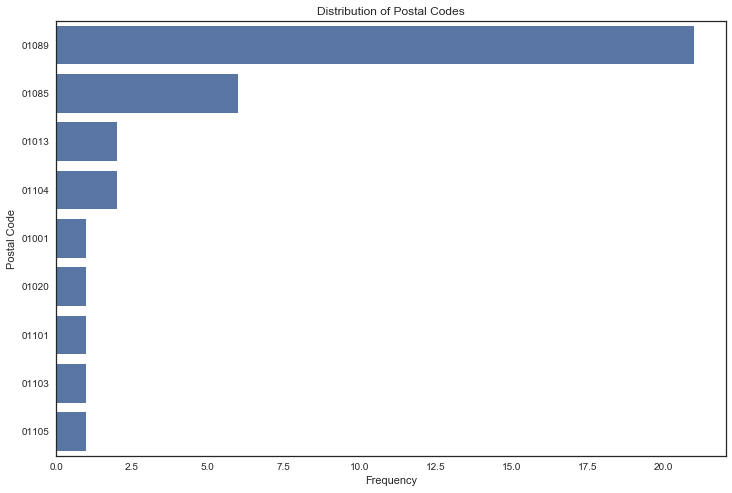

In [80]:


# This will show the distribution of postal codes
db = sqlite3.connect("west-springfield.db")
c = db.cursor()
query = '''
select value, count(*) as total from nodes_tags 
where key='postcode' group by value order by total desc;
'''
c.execute(query)
rows = c.fetchall()

df = pd.DataFrame(rows)
df = df.rename(columns={0: 'Postal_Code', 1: 'Frequency'})
df.Postal_Code = df.Postal_Code.astype('category')
# display(df)
plt.figure(figsize=(12,8))
sns.barplot(
    x='Frequency', 
    y='Postal_Code',
    data=df, 
    order=df.Postal_Code.tolist(), 
    color=colors[0])
plt.title('Distribution of Postal Codes')
plt.xlabel('Frequency')
plt.ylabel('Postal Code')
plt.show()

db.close()

In [123]:
def plot_bar(df, limit=None, x_var=None, log=False):
    if limit:
        df=df.iloc[:limit]
    df = df.rename(columns={0: x_var})
    plt.figure(figsize=(12,8))
    sns.barplot(
        y=x_var,
        x=1,
        data=df,
        color=colors[0]
    )
    
    plt.xlabel('Frequency')
    plt.show()

## Kinds of Amenities

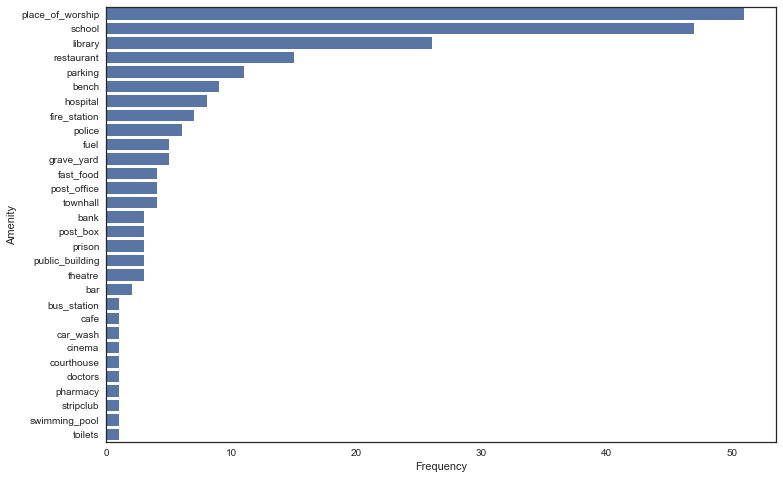

In [120]:
# This will show the distribution of amenities
db = sqlite3.connect("west-springfield.db")
c = db.cursor()
query = '''
select value, count(*) as total from nodes_tags
where key='amenity'
group by value order by total desc;
'''
c.execute(query)
rows = c.fetchall()
    
df = pd.DataFrame(rows)
plot_bar(df, x_var='Amenity')
db.close()

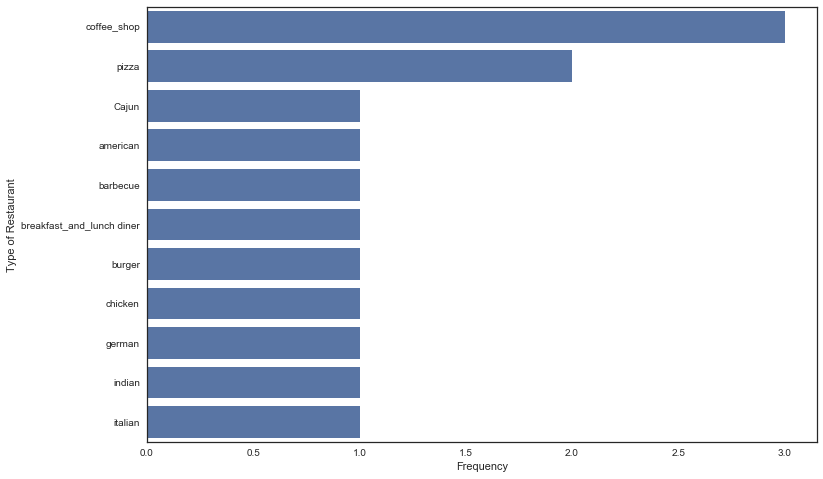

In [159]:
# This will show the distribution of restaurants
db = sqlite3.connect("west-springfield.db")
c = db.cursor()
query = '''
select value, count(*) as total from nodes_tags
where key='cuisine'
group by value order by total desc;
'''
c.execute(query)
rows = c.fetchall()
    
df = pd.DataFrame(rows)
plot_bar(df, x_var='Type of Restaurant')
# display(df)
db.close()

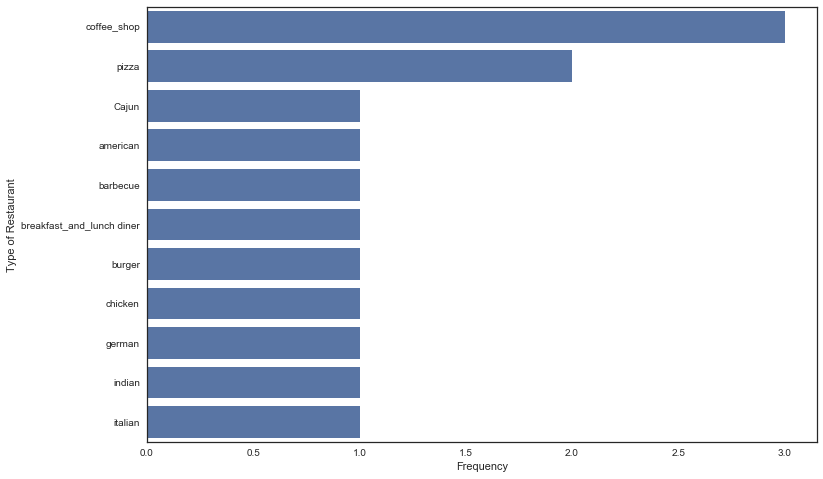

In [159]:
# This will show the distribution of restaurants
db = sqlite3.connect("west-springfield.db")
c = db.cursor()
query = '''
select name from nodes_tags
where key='cuisine'
'''
c.execute(query)
rows = c.fetchall()
    
df = pd.DataFrame(rows)
plot_bar(df, x_var='Type of Restaurant')
# display(df)
db.close()

## User Exploration

### Top 10 Contributors

Who were the top 10 ways and ways_tags contributors?

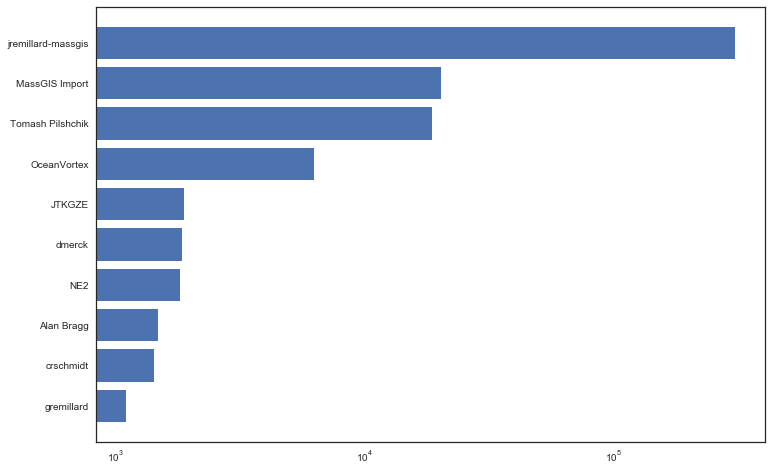

In [135]:
db = sqlite3.connect("west-springfield.db")
c = db.cursor()
query = '''
select user, count(*) as total
from (select user from nodes union all select user from ways)
group by user
order by total desc
limit 10;
'''
c.execute(query)
rows = c.fetchall()
    
df = pd.DataFrame(rows)
plt.figure(figsize=(12,8))
x=df[1]
y=range(9,-1,-1)
plt.barh(y,x, log=True)
plt.yticks(y, df.iloc[:10,0])

plt.show()
db.close()

### Nodes and Nodes Tags Contributions

How did the User Tomash Pilshchik contribute to the nodes and nodes_tags?

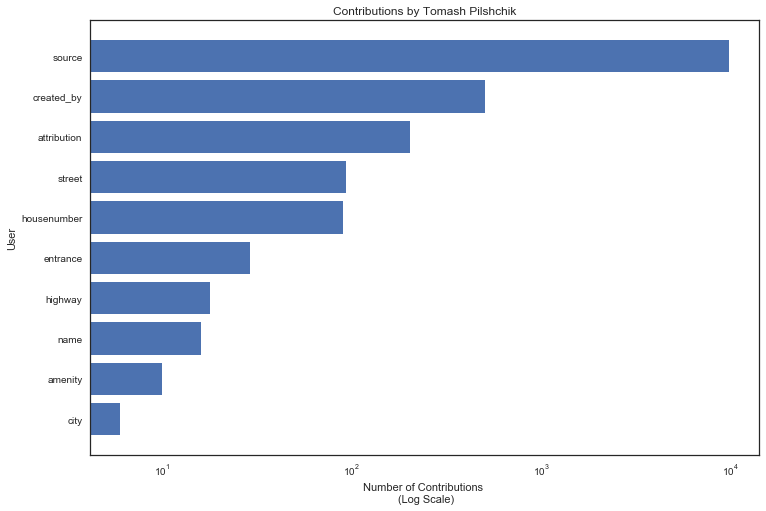

In [142]:
db = sqlite3.connect("west-springfield.db")
c = db.cursor()
query = '''
select key, count(*) as total
from nodes, nodes_tags
where nodes.id = nodes_tags.id and user='Tomash Pilshchik'
group by key
order by total desc
limit 10;
'''
c.execute(query)
rows = c.fetchall()
    
df = pd.DataFrame(rows)

plt.figure(figsize=(12,8))
x=df[1]
y=range(9,-1,-1)
plt.barh(y, x, log=True)
plt.yticks(y, df.iloc[:10,0])
plt.title('Contributions by Tomash Pilshchik')
plt.xlabel('Number of Contributions \n (Log Scale)')
plt.ylabel('User')
plt.show()

db.close()

### Ways and Ways Tags Contributions

How did the User Tomash Pilshchik contribute to the ways and ways tags?

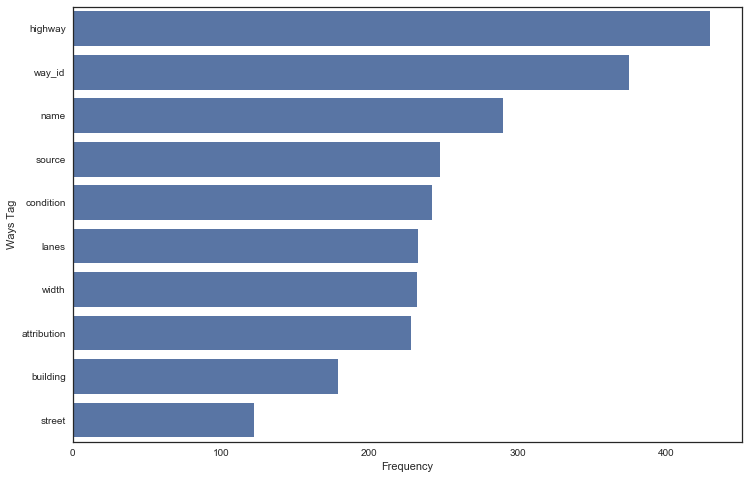

In [144]:
db = sqlite3.connect("west-springfield.db")
c = db.cursor()
query = '''
select key, count(*) as total
from ways, ways_tags
where ways.id = ways_tags.id and user='Tomash Pilshchik'
group by key
order by total desc;
'''
c.execute(query)
rows = c.fetchall()
    
df = pd.DataFrame(rows)  
plot_bar(df, limit=10, x_var='Ways Tag')
db.close()

## Types of Nodes Tags

This will show the distribution of nodes tags

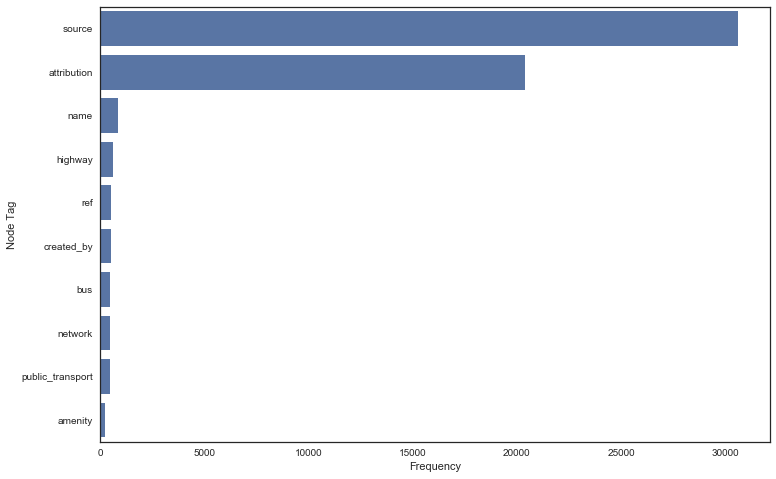

In [146]:
db = sqlite3.connect("west-springfield.db")
c = db.cursor()
query = '''
select key, count(*) as total from nodes_tags
group by key order by total desc;
'''
c.execute(query)
rows = c.fetchall()
    
df = pd.DataFrame(rows)
#display(df)  
plot_bar(df, limit=10, x_var="Node Tag")
db.close()

## Types of Ways Tags

This will show the distribution of ways tags

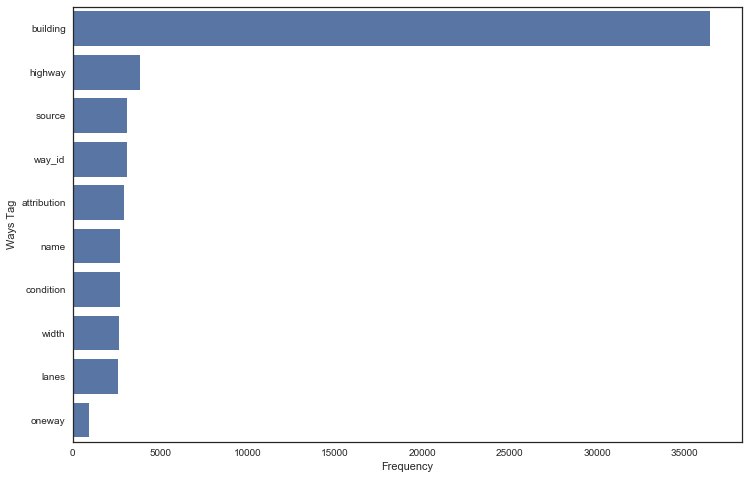

In [147]:
db = sqlite3.connect("west-springfield.db")
c = db.cursor()
query = '''
select key, count(*) as total from ways_tags
group by key order by total desc;
'''
c.execute(query)
rows = c.fetchall()
    
df = pd.DataFrame(rows)
plot_bar(df, limit=10, x_var="Ways Tag")

db.close()

## Types of Ways Highway Tags

This will show the distribution of highway tags

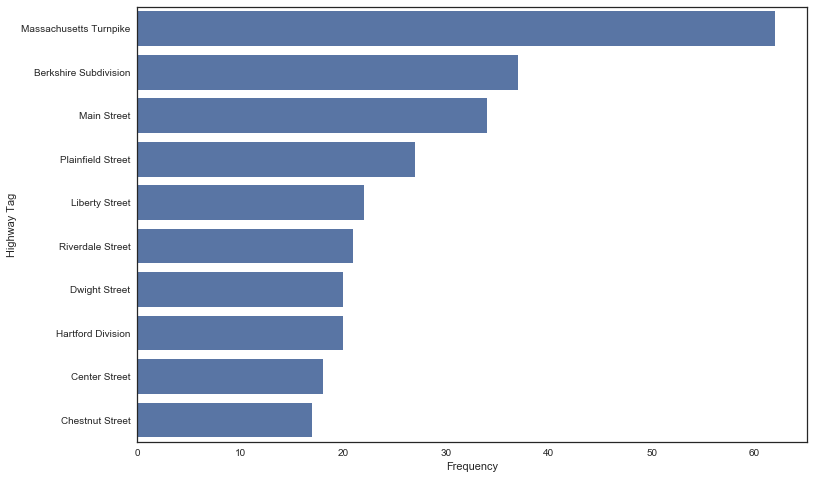

In [148]:
# This will show the distribution of postal codes
db = sqlite3.connect("west-springfield.db")
c = db.cursor()
query = '''
select value, count(*) as total from ways_tags
where key='name'
group by value order by total desc;
'''
c.execute(query)
rows = c.fetchall()

df = pd.DataFrame(rows)
plot_bar(df, limit=10, x_var="Highway Tag")

db.close()